In [38]:
import torch
import pandas as pd
import csv
import ast
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

In [2]:
# Initialize CLIP processor and model
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [25]:
root = './Predictions/'

vgg_predicted = root + "VGG-Transformer.csv"
vgg_df = pd.read_csv(vgg_predicted)

bilstm_predicted = root + "ViT-BiLSTM.csv"
bilstm_df = pd.read_csv(bilstm_predicted)

roberta_predicted = root + "ViT-Roberta.csv"
roberta_df = pd.read_csv(roberta_predicted)

In [26]:
vgg_json = {}

for index, row in vgg_df.iterrows():
    vgg_json[row['Image']] = row['Caption']

In [27]:
bilstm_json = {}

for index, row in bilstm_df.iterrows():
    bilstm_json[row['Image']] = row['Caption']

In [28]:
roberta_json = {}

for index, row in roberta_df.iterrows():
    roberta_json[row['Image']] = row['Caption']

In [33]:
header = ["Image", "Reference_Captions", "Chosen_Caption"]
clip_predictions = []

file_name = "Test-Images.csv"
df = pd.read_csv(file_name)
df = df.reset_index()

root = "./Predictions/"

for index, row in df.iterrows():
    image = row['Image']
    actual_captions = row['Captions']

    vgg = vgg_json[image]
    bilstm = bilstm_json[image]
    roberta = roberta_json[image]

    candidate_captions = [vgg, bilstm, roberta]

    inputs = clip_processor(text=candidate_captions, images=Image.open(image),
                            return_tensors="pt", padding=True)
    
    with torch.no_grad():
        outputs = clip_model(**inputs)

    # Extract logits
    logits = outputs.logits_per_image  # Shape: (batch_size, num_labels)

    # Find the index of the highest-scoring caption
    best_caption_index = torch.argmax(logits).item()
    best_caption = candidate_captions[best_caption_index]

    temp = [image, actual_captions, best_caption]
    clip_predictions.append(temp)

In [34]:
clip_predictions_file_name = "Clip-Predictions.csv"

with open(clip_predictions_file_name, 'w', newline = "") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    csvwriter.writerows(clip_predictions)

In [35]:
clip_df = pd.read_csv(clip_predictions_file_name)
clip_df.reset_index()

,index,Image,Reference_Captions,Chosen_Caption
0,0,./flickr8k/Images/1055623002_8195a43714.jpg,['a group of four children wearing pajamas hav...,a young boy is jumping on bed
1,1,./flickr8k/Images/107318069_e9f2ef32de.jpg,"['a crowd watching air balloons at night', 'a ...",a group of people are riding the air in the air
2,2,./flickr8k/Images/108898978_7713be88fc.jpg,"['skiiers walking up the hill through forest',...",A man in a red jacket and black pants is skiin...
3,3,./flickr8k/Images/1089181217_ee1167f7af.jpg,"['a brown dog running down paved pathw', 'a br...",a dog is running through the grass
4,4,./flickr8k/Images/109260216_85b0be5378.jpg,['a person climbing down sheer rock cliff usin...,A person climbs a rock
...,...,...,...,...
995,995,./flickr8k/Images/3033686219_452b172ab0.jpg,"['a black dog lays in the sand', 'a black dog ...",a black dog is running in the sand
996,996,./flickr8k/Images/2542037086_58c833699c.jpg,['a blonde haired boy is at the bottom of slid...,A little girl in a red shirt and blue jeans cl...
997,997,./flickr8k/Images/3480126681_52cea26bda.jpg,"['a black and white dog is running on sand', '...",A dog running on a dirt path
998,998,./flickr8k/Images/3251976937_20625dc2b8.jpg,['a brown dog holding huge stick in its mouth ...,A brown dog is running through snow


In [40]:
# calculating blue scores

bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0
mod = 1e9 + 7
length = 1000

for index, row in clip_df.iterrows():
    reference_captions = ast.literal_eval(row["Reference_Captions"])
    reference_captions_list = [element.split() for element in reference_captions]
    candidate_caption = row["Chosen_Caption"]
    candidate_caption_list = candidate_caption.split()
    bleu1 = (bleu1 + sentence_bleu(reference_captions_list, candidate_caption_list, weights=(1.0,0,0,0))) % mod
    bleu2 = (bleu2 + sentence_bleu(reference_captions_list, candidate_caption_list, weights=(0.5,0.5,0,0))) % mod
    bleu3 = (bleu3 + sentence_bleu(reference_captions_list, candidate_caption_list, weights=(0.3,0.3,0.3,0))) % mod
    bleu4 = (bleu4 + sentence_bleu(reference_captions_list, candidate_caption_list, weights=(0.25,0.25,0.25,0.25))) % mod


print(f"BLEU-1 score: {(bleu1/length) * 100}")
print(f"BLEU-2 score: {(bleu2/length) * 100}")
print(f"BLEU-3 score: {(bleu3/length) * 100}")
print(f"BLEU-4 score: {(bleu4/length) * 100}")

d:\Anaconda\envs\vitbilstm\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1 score: 52.66395959037822
BLEU-2 score: 30.0244837782841
BLEU-3 score: 15.09349470336673
BLEU-4 score: 5.233683197291617


In [41]:
# calculating meteor metric

meteor = 0
mod = 1e9 + 7

for index, row in clip_df.iterrows():
    reference_captions = ast.literal_eval(row["Reference_Captions"])
    reference_captions_list = [element.split() for element in reference_captions]
    candidate_caption = row["Chosen_Caption"]
    candidate_caption_list = candidate_caption.split()
    meteor = (meteor + meteor_score(reference_captions_list, candidate_caption_list)) % mod

print(f"METEOR score: {(meteor/length) * 100}")


METEOR score: 36.98089757160473


In [42]:
# calculating rouge metric

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_precision = 0
rouge1_recall = 0
rouge1_fmeasure = 0
rouge2_precision = 0
rouge2_recall = 0
rouge2_fmeasure = 0
rougeL_precision = 0
rougeL_recall = 0
rougeL_fmeasure = 0

obj = {
    'rouge1': [0, 0, 0],
    'rouge2': [0, 0, 0],
    'rougeL': [0, 0, 0]
}

for index, row in clip_df.iterrows():
    reference_captions = ast.literal_eval(row["Reference_Captions"])
    candidate_caption = row["Chosen_Caption"]
    scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    r1_p_max = 0
    r1_r_max = 0
    r1_f_max = 0
    r2_p_max = 0
    r2_r_max = 0
    r2_f_max = 0
    rL_p_max = 0
    rL_r_max = 0
    rL_f_max = 0
    for ref in reference_captions:
        temp_scores = scorer.score(ref, candidate_caption)
        r1_p_max = max(r1_p_max, temp_scores['rouge1'].precision)
        r1_r_max = max(r1_r_max, temp_scores['rouge1'].recall)
        r1_f_max = max(r1_f_max, temp_scores['rouge1'].fmeasure)

        r2_p_max = max(r2_p_max, temp_scores['rouge2'].precision)
        r2_r_max = max(r2_r_max, temp_scores['rouge2'].recall)
        r2_f_max = max(r2_f_max, temp_scores['rouge2'].fmeasure)

        rL_p_max = max(rL_p_max, temp_scores['rougeL'].precision)
        rL_r_max = max(rL_r_max, temp_scores['rougeL'].recall)
        rL_f_max = max(rL_f_max, temp_scores['rougeL'].fmeasure)
        
    obj['rouge1'][0] = (obj['rouge1'][0] + r1_p_max) % mod
    obj['rouge1'][1] = (obj['rouge1'][1] + r1_r_max) % mod
    obj['rouge1'][2] = (obj['rouge1'][2] + r1_f_max) % mod
    obj['rouge2'][0] = (obj['rouge2'][0] + r2_p_max) % mod
    obj['rouge2'][1] = (obj['rouge2'][1] + r2_r_max) % mod
    obj['rouge2'][2] = (obj['rouge2'][2] + r2_f_max) % mod
    obj['rougeL'][0] = (obj['rougeL'][0] + rL_p_max) % mod
    obj['rougeL'][1] = (obj['rougeL'][1] + rL_r_max) % mod
    obj['rougeL'][2] = (obj['rougeL'][2] + rL_f_max) % mod


size = length
print(f'Rouge1: Precision = {obj["rouge1"][0] * 100 / size}, Recall = {obj["rouge1"][1] * 100 / size}, f_measure = {obj["rouge1"][2] * 100 / size}')
print(f'Rouge2: Precision = {obj["rouge2"][0] * 100 / size}, Recall = {obj["rouge2"][1] * 100 / size}, f_measure = {obj["rouge2"][2] * 100 / size}')
print(f'RougeL: Precision = {obj["rougeL"][0] * 100 / size}, Recall = {obj["rougeL"][1] * 100 / size}, f_measure = {obj["rougeL"][2] * 100 / size}')

Rouge1: Precision = 45.055555970059906, Recall = 48.993245325384756, f_measure = 43.78991734763117
Rouge2: Precision = 20.651735540347357, Recall = 22.496715671669207, f_measure = 20.33787473434075
RougeL: Precision = 42.637260364126696, Recall = 47.23208033489967, f_measure = 41.836033710552876


Image: ./flickr8k/Images/390992102_67fa31b22f.jpg
Ground Truth: ['a hiker climbs mountain on windy day', 'a man walking up mountain with snow on the surfa', 'a person hikes across grass and snow covered pla', 'person walking across snow covered mountain', 'the man carries large backpack while hiking through snow-covered terrain']
Predicted Caption: A person in a red jacket and black pants is hiking through a snowy mountain


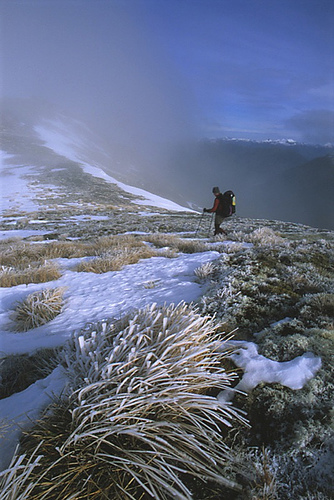

In [97]:
# For testing purpose

random_row = clip_df.sample()
image = random_row['Image']
ground_truth = random_row['Reference_Captions']
pred_caption = random_row['Chosen_Caption']
print(f"Image: {image.values[0]}")
print(f"Ground Truth: {ground_truth.values[0]}")
print(f"Predicted Caption: {pred_caption.values[0]}")
Image.open(image.values[0])